## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [157]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [158]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [159]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [160]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [161]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [162]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [163]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [164]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [165]:
target = 'survived'

In [166]:
vars_num = [var for var in data.columns if data[var].dtypes != 'O' and var != target] #O here is object

vars_cat = [var for var in data.columns if data[var].dtypes == 'O' and var != target]

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


In [177]:
data['cabin'].dtype

dtype('O')

### Find missing values in variables

In [178]:
# first in numerical variables
vars_with_na_n = [var for var in vars_num if data[var].isnull().sum() > 0]

for var in vars_with_na_n:
    print(var, np.round(data[var].isnull().mean(), 3), ' % missing values')



age 0.201  % missing values
fare 0.001  % missing values


In [179]:
# now in categorical variables
vars_with_na_c = [var for var in vars_cat if data[var].isnull().sum() > 0 and data[var].dtypes == 'O']

for var in vars_with_na_c:
    print(var, np.round(data[var].isnull().mean(), 3), ' % missing values')



cabin 0.775  % missing values
embarked 0.002  % missing values


### Determine cardinality of categorical variables

In [180]:
for var in vars_cat:
    print(var, data[var].nunique(), ' categories')
#function to display all unique values

sex 2  categories
cabin 181  categories
embarked 3  categories
title 5  categories


### Determine the distribution of numerical variables

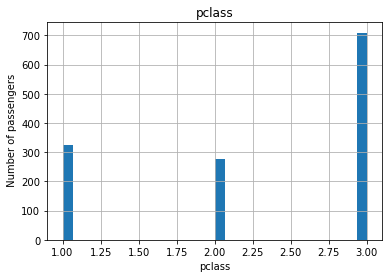

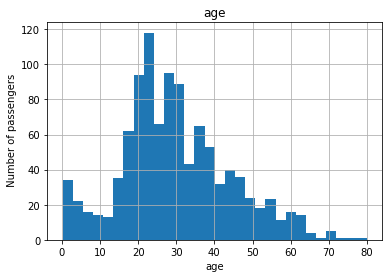

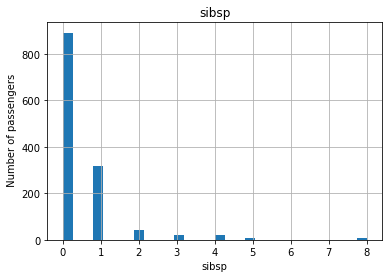

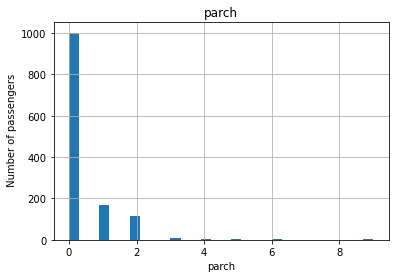

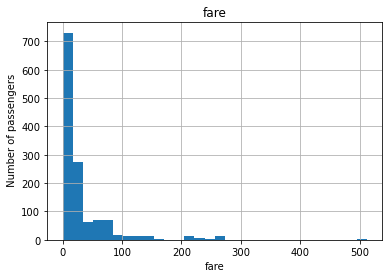

In [181]:
def analyse_continuous(df, var):
    df = data.copy()
    df[var].hist(bins=30)
    plt.ylabel(' Number of passengers')
    plt.xlabel(var)
    plt.title(var)
    plt.show()
    

for var in vars_num:
    analyse_continuous(data,var)

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [182]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [183]:
X_train['cabin'] = X_train['cabin'].astype(str).str[0]
X_test['cabin'] = X_test['cabin'].astype(str).str[0]


In [184]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title
1118,3,male,25.0,0,0,7.9250,n,S,Mr
44,1,female,41.0,0,0,134.5000,E,C,Miss
1072,3,male,NaN,0,0,7.7333,n,Q,Mr
1130,3,female,18.0,0,0,7.7750,n,S,Miss
574,2,male,29.0,1,0,21.0000,n,S,Mr


### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [185]:
def fill_na(train, test, column):
    median = train[column].median()
    train[column+'_NA'] = np.where(train[column].isnull(), 1, 0)
    test[column+'_NA'] = np.where(test[column].isnull(),1,0)
    train[column].fillna(value=median, inplace = True)
    test[column].fillna(value=median, inplace = True)

In [186]:
#finding error in question when using median. works when mode is used.

In [187]:
for column in vars_with_na_n:
    fill_na(X_train, X_test, column)

In [188]:
X_train.head()

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_NA,fare_NA
1118,3,male,25.0,0,0,7.9250,n,S,Mr,0,0
44,1,female,41.0,0,0,134.5000,E,C,Miss,0,0
1072,3,male,28.0,0,0,7.7333,n,Q,Mr,1,0
1130,3,female,18.0,0,0,7.7750,n,S,Miss,0,0
574,2,male,29.0,1,0,21.0000,n,S,Mr,0,0


### Replace Missing data in categorical variables with the string **Missing**

In [191]:
def fill_na_c(train, test, column):
    
    train[column].fillna(value='Missing', inplace = True)
    test[column].fillna(value='Missing', inplace = True)

In [192]:
for column in vars_with_na_c:
    fill_na_c(X_train, X_test,column)

In [193]:
X_train[vars_cat].isnull().sum()

sex         0
cabin       0
embarked    0
title       0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [194]:
def find_frequent_labels(df, var, rare_perc):
    
    df = df.copy()
    
    tmp  = df[var].value_counts() / len(df[var])
    
    return tmp[tmp > rare_perc].index

for var in vars_cat:
    
    frequent_ls = find_frequent_labels(X_train, var, 0.05)
    
    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var], 'Rare')
 

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [195]:
X_train = pd.get_dummies(X_train, columns = vars_cat, drop_first = True)

In [196]:
X_train.columns

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'age_NA', 'fare_NA',
       'sex_male', 'cabin_Rare', 'cabin_n', 'embarked_Q', 'embarked_Rare',
       'embarked_S', 'title_Mr', 'title_Mrs', 'title_Rare'],
      dtype='object')

In [197]:
X_train.embarked_Rare.value_counts()

0    1045
1       2
Name: embarked_Rare, dtype: int64

In [198]:
X_test = pd.get_dummies(X_test, columns = vars_cat, drop_first = True)

In [199]:
X_test['embarked_Rare'] = 0

In [200]:
len(X_test.columns) == len(X_train.columns)

True

In [201]:
X_train.shape, X_test.shape

((1047, 16), (262, 16))

### Scale the variables

- Use the standard scaler from Scikit-learn

In [202]:
scaler = StandardScaler()
scaler.fit(X_train) #for scaling / normalizing


StandardScaler()

## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [203]:
logreg = LogisticRegression(random_state =42, C = 0.0005)

In [204]:
logreg.fit(X_train, y_train)

LogisticRegression(C=0.0005, random_state=42)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [205]:
y_predict = logreg.predict(X_train)
y_probs = logreg.predict_proba(X_train)
train_acc_score = accuracy_score(y_train, y_predict)
train_roc_auc = roc_auc_score(y_train, y_probs[:,1]) #why the[:,1] here?

print('train set accuracy: ', train_acc_score)
print('train set AUC-ROC: ', train_roc_auc)


y_predict = logreg.predict(X_test)
y_probs = logreg.predict_proba(X_test)
test_acc_score = accuracy_score(y_test, y_predict)
test_roc_auc = roc_auc_score(y_test, y_probs[:,1]) #why the[:,1] here?

print('train set accuracy: ', test_acc_score)
print('train set AUC-ROC: ', test_roc_auc)

train set accuracy:  0.670487106017192
train set AUC-ROC:  0.751306027820711
train set accuracy:  0.6564885496183206
train set AUC-ROC:  0.7475


That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**